In [1]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

#from albumentations.pytorch import ToTensor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from AlbumentationTransforms import AlbumentationTransform
from dataloader import getDataLoader
from models import resnet18
#import train

In [4]:
if(torch.cuda.is_available):
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
'''
train_transform = transforms.Compose([
     #transforms.CenterCrop((100, 100)),
     #transforms.Grayscale(),
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,  0.2435,  0.2616)),
     ])
'''

'\ntrain_transform = transforms.Compose([\n     #transforms.CenterCrop((100, 100)),\n     #transforms.Grayscale(),\n     transforms.RandomCrop(32, padding=4),\n     transforms.RandomHorizontalFlip(p=0.5),\n     transforms.RandomRotation(degrees=(-90, 90)),\n     transforms.RandomVerticalFlip(p=0.5),\n     transforms.ToTensor(),\n     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,  0.2435,  0.2616)),\n     ])\n'

In [6]:
'''
test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,  0.2435,  0.2616)),
     ])
'''

'\ntest_transform = transforms.Compose([\n     transforms.ToTensor(),\n     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,  0.2435,  0.2616)),\n     ])\n'

In [7]:
import albumentations as AL
import albumentations.pytorch as AT

In [8]:
train_transform = AlbumentationTransform([
                                       AL.RandomCrop(32, 32),
                                       AL.Rotate((-30.0, 30.0)),
                                       AL.HorizontalFlip(p=0.5),
                                       AL.RandomBrightness(),
                                       AL.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                       AL.Cutout(num_holes=1, max_h_size=16, max_w_size = 16, p=1),
                                       AT.ToTensor()
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransform([AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), AT.ToTensor()])

In [9]:
trainloader, testloader = getDataLoader('CIFAR10', 32, train_transform, test_transform)

Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

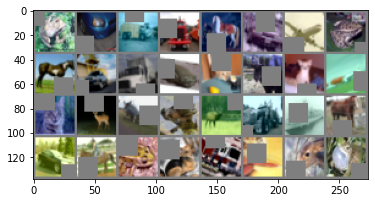

 frog   car truck truck


In [13]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

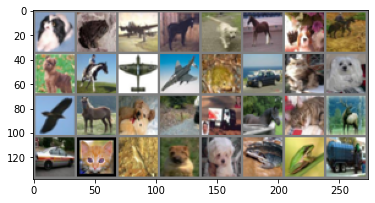

  dog  frog plane horse


In [15]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = resnet18.ResNet18()

In [17]:
net = net.to(device)

In [18]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [23]:
from lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



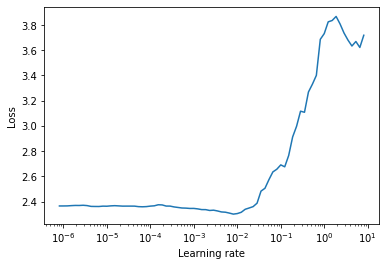

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7,  momentum = 0.9)#weight_decay=1e-2)
lr_finder = LRFinder(net, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [21]:
'''
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder1 = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder1.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100, step_mode="linear")
lr_finder1.plot(log_lr=False)
lr_finder1.reset()
'''

'\ncriterion1 = nn.CrossEntropyLoss()\noptimizer1 = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-2)\nlr_finder1 = LRFinder(net, optimizer, criterion, device="cuda")\nlr_finder1.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100, step_mode="linear")\nlr_finder1.plot(log_lr=False)\nlr_finder1.reset()\n'

In [25]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)#, weight_decay=1e-2)

In [26]:
import train

net, train_accuracy, train_losses = train.cifar10train(net, device, trainloader, optimizer, criterion, epochs=50)

loss=0.9642253518104553 batch_id=1562 Accuracy = 38.56:   0%|          | 0/1563 [00:41<?, ?it/s]


Train set: Average loss: 0.0533, Accuracy: 19282/50000 (38.56%)


loss=1.1796106100082397 batch_id=1562 Accuracy = 55.82:   0%|          | 0/1563 [01:23<?, ?it/s]


Train set: Average loss: 0.0390, Accuracy: 27912/50000 (55.82%)


loss=1.3807764053344727 batch_id=1562 Accuracy = 63.50:   0%|          | 0/1563 [02:05<?, ?it/s]


Train set: Average loss: 0.0326, Accuracy: 31750/50000 (63.50%)


loss=0.6185308694839478 batch_id=1562 Accuracy = 68.08:   0%|          | 0/1563 [02:46<?, ?it/s]


Train set: Average loss: 0.0287, Accuracy: 34038/50000 (68.08%)


loss=0.6594359874725342 batch_id=1562 Accuracy = 70.97:   0%|          | 0/1563 [03:28<?, ?it/s]


Train set: Average loss: 0.0262, Accuracy: 35486/50000 (70.97%)


loss=1.2980804443359375 batch_id=1562 Accuracy = 72.83:   0%|          | 0/1563 [04:10<?, ?it/s]


Train set: Average loss: 0.0243, Accuracy: 36413/50000 (72.83%)


loss=1.1196939945220947 batch_id=1562 Accuracy = 74.87:   0%|          | 0/1563 [04:51<?, ?it/s]


Train set: Average loss: 0.0226, Accuracy: 37437/50000 (74.87%)


loss=0.29458603262901306 batch_id=1562 Accuracy = 76.31:   0%|          | 0/1563 [05:33<?, ?it/s]


Train set: Average loss: 0.0212, Accuracy: 38157/50000 (76.31%)


loss=0.649009108543396 batch_id=1562 Accuracy = 77.69:   0%|          | 0/1563 [06:14<?, ?it/s]


Train set: Average loss: 0.0201, Accuracy: 38847/50000 (77.69%)


loss=0.8926876783370972 batch_id=1562 Accuracy = 78.86:   0%|          | 0/1563 [06:56<?, ?it/s]


Train set: Average loss: 0.0190, Accuracy: 39428/50000 (78.86%)


loss=1.3781960010528564 batch_id=1562 Accuracy = 79.94:   0%|          | 0/1563 [07:38<?, ?it/s]


Train set: Average loss: 0.0180, Accuracy: 39971/50000 (79.94%)


loss=0.5528948307037354 batch_id=1562 Accuracy = 81.21:   0%|          | 0/1563 [08:20<?, ?it/s]


Train set: Average loss: 0.0170, Accuracy: 40604/50000 (81.21%)


loss=0.7361277937889099 batch_id=1562 Accuracy = 81.67:   0%|          | 0/1563 [09:01<?, ?it/s] 


Train set: Average loss: 0.0165, Accuracy: 40836/50000 (81.67%)


loss=0.43318086862564087 batch_id=1562 Accuracy = 82.74:   0%|          | 0/1563 [09:43<?, ?it/s]


Train set: Average loss: 0.0156, Accuracy: 41372/50000 (82.74%)


loss=0.39883846044540405 batch_id=1562 Accuracy = 83.06:   0%|          | 0/1563 [10:25<?, ?it/s]


Train set: Average loss: 0.0153, Accuracy: 41532/50000 (83.06%)


loss=0.5890121459960938 batch_id=1562 Accuracy = 83.91:   0%|          | 0/1563 [11:06<?, ?it/s] 


Train set: Average loss: 0.0145, Accuracy: 41953/50000 (83.91%)


loss=0.7317092418670654 batch_id=1562 Accuracy = 84.41:   0%|          | 0/1563 [11:47<?, ?it/s]


Train set: Average loss: 0.0138, Accuracy: 42206/50000 (84.41%)


loss=0.29011309146881104 batch_id=1562 Accuracy = 85.16:   0%|          | 0/1563 [12:29<?, ?it/s]


Train set: Average loss: 0.0134, Accuracy: 42582/50000 (85.16%)


loss=0.3392201364040375 batch_id=1562 Accuracy = 85.38:   0%|          | 0/1563 [13:10<?, ?it/s]


Train set: Average loss: 0.0131, Accuracy: 42688/50000 (85.38%)


loss=0.23745258152484894 batch_id=1562 Accuracy = 85.84:   0%|          | 0/1563 [13:52<?, ?it/s]


Train set: Average loss: 0.0127, Accuracy: 42918/50000 (85.84%)


loss=0.2966349720954895 batch_id=1562 Accuracy = 86.35:   0%|          | 0/1563 [14:34<?, ?it/s]


Train set: Average loss: 0.0121, Accuracy: 43175/50000 (86.35%)


loss=0.33570584654808044 batch_id=1562 Accuracy = 87.11:   0%|          | 0/1563 [15:16<?, ?it/s]


Train set: Average loss: 0.0115, Accuracy: 43553/50000 (87.11%)


loss=0.43181726336479187 batch_id=1562 Accuracy = 87.18:   0%|          | 0/1563 [15:58<?, ?it/s]


Train set: Average loss: 0.0114, Accuracy: 43588/50000 (87.18%)


loss=0.471274733543396 batch_id=1562 Accuracy = 87.34:   0%|          | 0/1563 [16:40<?, ?it/s] 


Train set: Average loss: 0.0112, Accuracy: 43671/50000 (87.34%)


loss=0.272582471370697 batch_id=1562 Accuracy = 88.20:   0%|          | 0/1563 [17:21<?, ?it/s]  


Train set: Average loss: 0.0105, Accuracy: 44098/50000 (88.20%)


loss=0.327797532081604 batch_id=1562 Accuracy = 88.48:   0%|          | 0/1563 [18:03<?, ?it/s]  


Train set: Average loss: 0.0104, Accuracy: 44238/50000 (88.48%)


loss=0.9529123902320862 batch_id=1562 Accuracy = 88.72:   0%|          | 0/1563 [18:44<?, ?it/s]


Train set: Average loss: 0.0100, Accuracy: 44358/50000 (88.72%)


loss=0.3740007281303406 batch_id=1562 Accuracy = 89.33:   0%|          | 0/1563 [19:26<?, ?it/s] 


Train set: Average loss: 0.0096, Accuracy: 44667/50000 (89.33%)


loss=0.25917115807533264 batch_id=1562 Accuracy = 88.87:   0%|          | 0/1563 [20:08<?, ?it/s]


Train set: Average loss: 0.0098, Accuracy: 44434/50000 (88.87%)


loss=0.29091787338256836 batch_id=1562 Accuracy = 89.89:   0%|          | 0/1563 [20:50<?, ?it/s]


Train set: Average loss: 0.0092, Accuracy: 44947/50000 (89.89%)


loss=0.22700044512748718 batch_id=1562 Accuracy = 90.05:   0%|          | 0/1563 [21:32<?, ?it/s]


Train set: Average loss: 0.0089, Accuracy: 45023/50000 (90.05%)


loss=0.23705244064331055 batch_id=1562 Accuracy = 90.34:   0%|          | 0/1563 [22:14<?, ?it/s]


Train set: Average loss: 0.0087, Accuracy: 45169/50000 (90.34%)


loss=0.8524186611175537 batch_id=1562 Accuracy = 90.47:   0%|          | 0/1563 [22:55<?, ?it/s] 


Train set: Average loss: 0.0087, Accuracy: 45236/50000 (90.47%)


loss=0.8184047937393188 batch_id=1562 Accuracy = 90.66:   0%|          | 0/1563 [23:37<?, ?it/s]


Train set: Average loss: 0.0084, Accuracy: 45330/50000 (90.66%)


loss=0.18519824743270874 batch_id=1562 Accuracy = 90.89:   0%|          | 0/1563 [24:19<?, ?it/s]


Train set: Average loss: 0.0082, Accuracy: 45444/50000 (90.89%)


loss=0.2203652262687683 batch_id=1562 Accuracy = 91.26:   0%|          | 0/1563 [25:01<?, ?it/s]


Train set: Average loss: 0.0079, Accuracy: 45630/50000 (91.26%)


loss=0.1312316507101059 batch_id=1562 Accuracy = 91.34:   0%|          | 0/1563 [25:43<?, ?it/s]


Train set: Average loss: 0.0078, Accuracy: 45668/50000 (91.34%)


loss=0.2003737986087799 batch_id=1562 Accuracy = 91.56:   0%|          | 0/1563 [26:24<?, ?it/s]


Train set: Average loss: 0.0076, Accuracy: 45780/50000 (91.56%)


loss=0.1935647875070572 batch_id=1562 Accuracy = 91.78:   0%|          | 0/1563 [27:06<?, ?it/s] 


Train set: Average loss: 0.0074, Accuracy: 45888/50000 (91.78%)


loss=0.023778527975082397 batch_id=1562 Accuracy = 92.04:   0%|          | 0/1563 [27:47<?, ?it/s]


Train set: Average loss: 0.0072, Accuracy: 46022/50000 (92.04%)


loss=0.17089836299419403 batch_id=1562 Accuracy = 92.03:   0%|          | 0/1563 [28:29<?, ?it/s]


Train set: Average loss: 0.0072, Accuracy: 46013/50000 (92.03%)


loss=0.22962477803230286 batch_id=1562 Accuracy = 92.14:   0%|          | 0/1563 [29:11<?, ?it/s]


Train set: Average loss: 0.0070, Accuracy: 46070/50000 (92.14%)


loss=0.2879582345485687 batch_id=1562 Accuracy = 92.28:   0%|          | 0/1563 [29:53<?, ?it/s]


Train set: Average loss: 0.0068, Accuracy: 46141/50000 (92.28%)


loss=0.3035263419151306 batch_id=1562 Accuracy = 92.37:   0%|          | 0/1563 [30:35<?, ?it/s]


Train set: Average loss: 0.0068, Accuracy: 46183/50000 (92.37%)


loss=0.43252453207969666 batch_id=1562 Accuracy = 92.81:   0%|          | 0/1563 [31:16<?, ?it/s]


Train set: Average loss: 0.0065, Accuracy: 46405/50000 (92.81%)


loss=0.39954206347465515 batch_id=1562 Accuracy = 92.89:   0%|          | 0/1563 [31:58<?, ?it/s]


Train set: Average loss: 0.0064, Accuracy: 46444/50000 (92.89%)


loss=0.12603650987148285 batch_id=1562 Accuracy = 93.01:   0%|          | 0/1563 [32:40<?, ?it/s]


Train set: Average loss: 0.0063, Accuracy: 46505/50000 (93.01%)


loss=0.035875946283340454 batch_id=1562 Accuracy = 93.16:   0%|          | 0/1563 [33:21<?, ?it/s]


Train set: Average loss: 0.0061, Accuracy: 46579/50000 (93.16%)


loss=0.5807616710662842 batch_id=1562 Accuracy = 93.09:   0%|          | 0/1563 [34:03<?, ?it/s] 


Train set: Average loss: 0.0061, Accuracy: 46543/50000 (93.09%)


loss=0.5490766763687134 batch_id=1562 Accuracy = 93.28:   0%|          | 0/1563 [34:44<?, ?it/s] 


Train set: Average loss: 0.0060, Accuracy: 46639/50000 (93.28%)
Finished Training


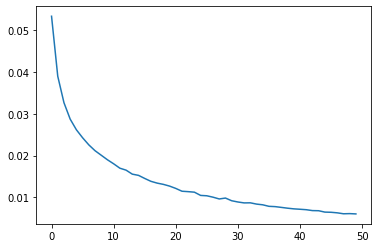

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_losses)

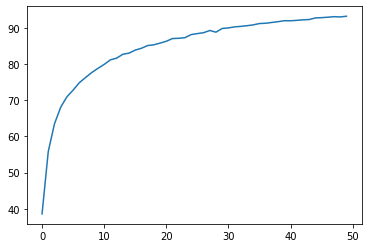

In [28]:
plt.plot(train_accuracy)

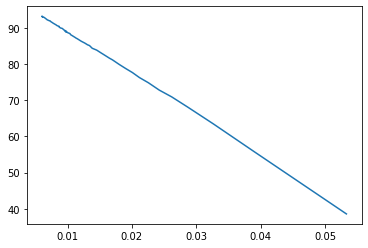

In [29]:
plt.plot(train_losses, train_accuracy)

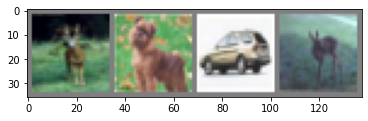

GroundTruth:   deer   dog   car  deer


In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
images = images[:4].to(device)
outputs = net(images)

In [34]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer   dog   car  deer


In [30]:
net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %
